定义绘图函数

In [40]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import os
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['font.family']='SimHei'

# 定义站点数据
data = """
丰镇（饮三）	30704390	33.19315084
新井	20115700	2278.330549
杨树湾子（三）	20114200	81.43852579
哈拉道口	20116590	5703.514928
台河口（西五）	20205510	2341.733645
万合永	20208000	5374.964692
梅林庙（二）	20308000	887.0615005
白音他拉	20310500	12389.25439
文得根	11300301	1000.865057
东园（四）	40515500	440.211515
美岱（大二）	40516200	58.23118654
店上村（三）	40517100	1383.231343
活福滩（二）	1717100	1332.856413
百灵庙（四）	1718900	1333.321466
索伦	11420050	995.2732966
锦山（三）	20113001	673.7204632
乌丹（四）	20213000	27253.42109
塔尔湾（二）	40514300	938.2772916
红山口（三）	40516800	61.74119509
转龙湾	40701050	96.4394109
"""


def plot_precip_flow(output_folder, nc_file, basin_columns, precip_var, flow_var_obs, flow_var_pred, target_basin_id, time_style, time_start=None, time_end=None, station_dict=None):
    try:
        ds = xr.open_dataset(nc_file)
        
        # 确保输出文件夹存在，如果不存在则创建
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # 检查是否存在指定的basin_colunms
        if target_basin_id in ds[basin_colunms].values:
            print(f"Processing {nc_file} with basin_id {target_basin_id}")
            
            # 提取指定basin_id的数据
            basin_data = ds.sel({basin_colunms: target_basin_id})
            
            # 如果有时间范围，进行时间筛选
            if time_start and time_end:
                basin_data = basin_data.sel(time=slice(time_start, time_end))
            
            # 提取时间序列数据
            time = basin_data['time']
            precip = basin_data[precip_var]
            
            # 读取流量预测和实测数据
            flow_obs = xr.open_dataset(flow_var_obs).sel({basin_colunms: target_basin_id}).sel(time=slice(time_start, time_end))['streamflow']
            flow_pred = xr.open_dataset(flow_var_pred).sel({basin_colunms: target_basin_id}).sel(time=slice(time_start, time_end))['streamflow']


            # 将数据分割成行
            lines = data.strip().split('\n')
            station_dict = {}

            for line in lines:
                station_name, station_number, basin_area = line.split('\t')
                # 将站点名称转换为字符串，并加上前缀 'neimenggu_'
                station_dict['neimenggu_' + station_number] = {
                    'name': station_name,
                    'basin_area': float(basin_area)
                }

            
            # 字典获取流域
            if target_basin_id in station_dict:
                
                basin_info = station_dict[target_basin_id]
                
                target_basin_id = basin_info['name']
                
                basin_area = basin_info['basin_area']
            else:
                
                print(f"{target_basin_id} not found in station_dict")
            
            # 创建图表
            fig, ax1 = plt.subplots(figsize=(10, 6))
            
            # 降水图（柱状图，宽度调整为0.5）
            ax1.bar(time, precip, width=0.1, color='blue', alpha=0.6, label='Precipitation')
            ax1.set_ylabel('降雨值 (mm)', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')
            
            # 只显示最大降水量的1/3
            ax1.set_ylim(0, precip.max() * 5)
            ax1.invert_yaxis()  # 降水量图表倒置显示
            
            # 添加第二个y轴用于流量图
            ax2 = ax1.twinx()
            m3_s = 0 
            
            # 单位转化
            if time_style == '1D':
                flow_obs= flow_obs*86.4/basin_area
                flow_pred =  flow_pred*86.4/basin_area

            elif time_style == '3h':
                flow_obs= flow_obs*10.8/basin_area
                flow_pred =  flow_pred*10.8/basin_area

            else: # time_style == '1h'
                flow_obs= flow_obs*3.6/basin_area
                flow_pred =  flow_pred*3.6/basin_area

            ax2.plot(time, flow_obs, color='green',linestyle='-', label='观测值')
            ax2.plot(time, flow_pred, color='red', linestyle='--', label='预测值')
            ax2.set_ylabel('径流值 (m^3/s)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            
            # 设置标题和图例
            plt.title(f'{target_basin_id}水文站 降雨与径流时序图')
            
            plt.legend(loc='upper left')
            
            plt.savefig(f"{output_folder}/{target_basin_id}_{time_start}-{time_end}.png")
            
            # 关闭数据集
            ds.close()
        else:
            print(f"{target_basin_id} not found in {nc_file}")
    except Exception as e:
        print(f"An error occurred  {e}")

根据流域id绘制图像

Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510


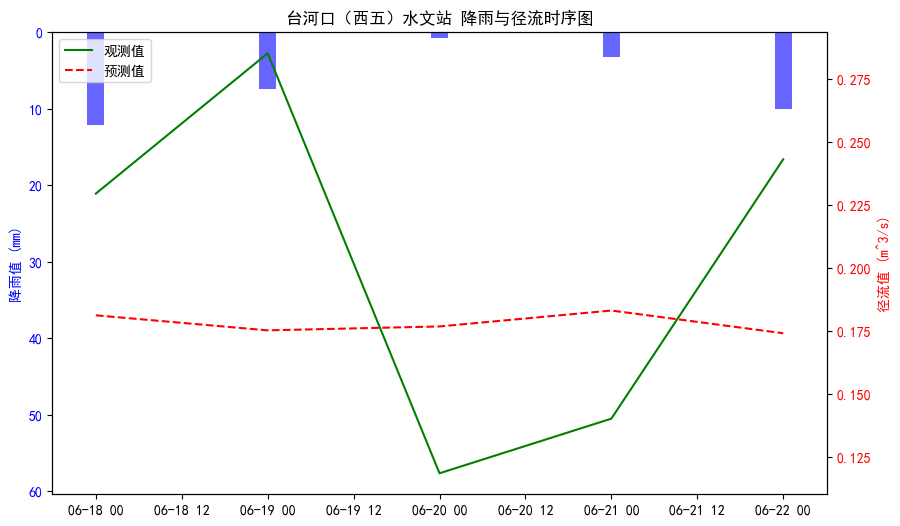

In [16]:
time_style = '1D' # 时间尺度

output_folder =f'./plt_mtlflow_{time_style}'
basin_colunms = "basin"
precip_var = "total_precipitation_hourly"

# basin_ids = ['neimenggu_11300301', 'neimenggu_20115700', 'neimenggu_20114200', 'neimenggu_20116590', 'neimenggu_20205510', 'neimenggu_20208000', 'neimenggu_20308000', 'neimenggu_20310500', 'neimenggu_30704390', 'neimenggu_40515500', 'neimenggu_40517100']
basin_id = 'neimenggu_20205510'

nc_file = f"/home/zlh/.cache/hydro/timeseries_{time_style}_batch_neimenggu_11300301_neimenggu_40701050.nc" # nc文件

flow_var_obs =f"/home/zlh/HydroNeimeng/scripts/results/test_with_era5land/train_with_camelsandneimeng_{time_style}_era5land_mtlflow/epochbest_model.pthflow_obs.nc" # 实测文件
flow_var_pred =f"/home/zlh/HydroNeimeng/scripts/results/test_with_era5land/train_with_camelsandneimeng_{time_style}_era5land_mtlflow/epochbest_model.pthflow_pred.nc" # 预测文件

plot_precip_flow(output_folder, nc_file, basin_colunms, precip_var, flow_var_obs, flow_var_pred, basin_id ,time_style, time_start="2001-06-18", time_end="2001-06-22")

根据场次划分文件event.csv绘制图像

当前流域： neimenggu_20205510 时间段： 2001-02-26 至 2001-04-29
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
An error occurred  x and y must have same first dimension, but have shapes (63,) and (0,)
当前流域： neimenggu_20205510 时间段： 2001-05-19 至 2001-07-22
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
An error occurred  x and y must have same first dimension, but have shapes (65,) and (53,)
当前流域： neimenggu_20205510 时间段： 2002-02-02 至 2002-04-04
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2002-02-12 至 2002-04-16
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2002-02-26 至 2002-04-29
Processing /home/zlh/.cache/hydro/tim

/tmp/ipykernel_2914654/1167867736.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(10, 6))


当前流域： neimenggu_20205510 时间段： 2006-06-04 至 2006-08-05
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2007-02-16 至 2007-04-20
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2007-02-21 至 2007-04-22
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2007-02-27 至 2007-04-30
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2007-03-11 至 2007-05-10
Processing /home/zlh/.cache/hydro/timeseries_1D_batch_neimenggu_11300301_neimenggu_40701050.nc with basin_id neimenggu_20205510
当前流域： neimenggu_20205510 时间段： 2007-03-13 至 2007-08-17
Processing /home/zlh/.cache/hydro/ti

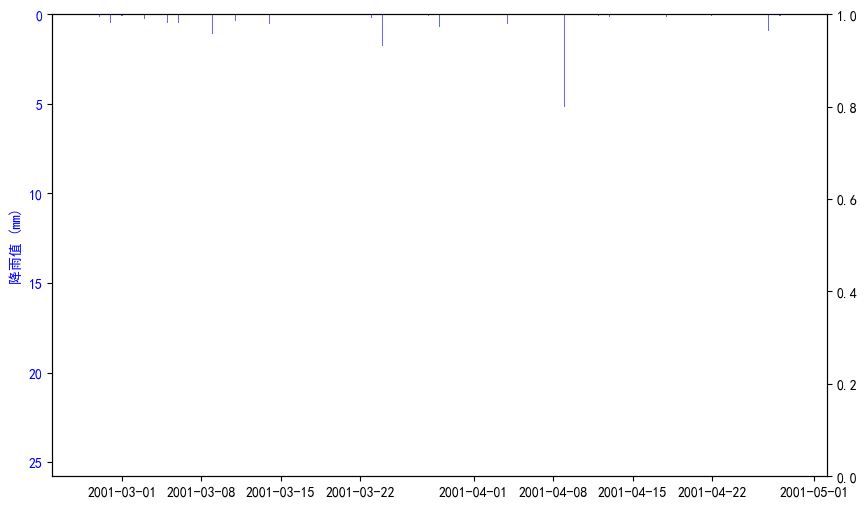

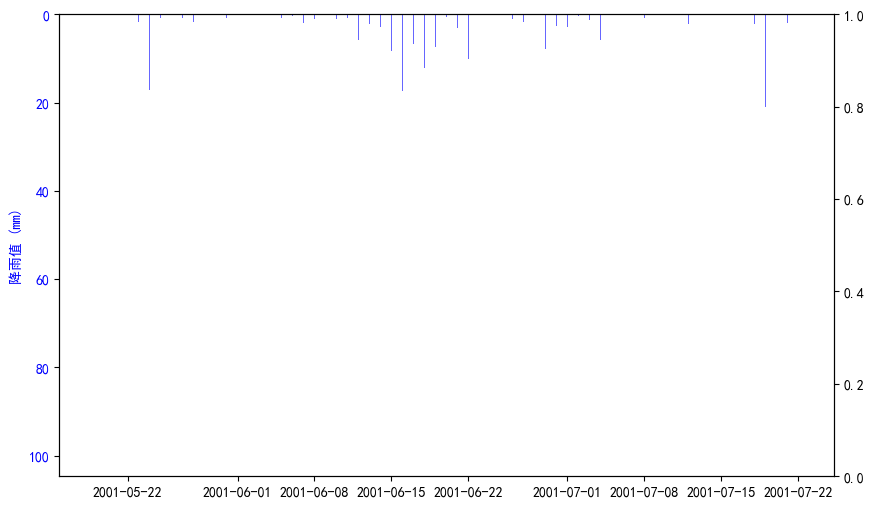

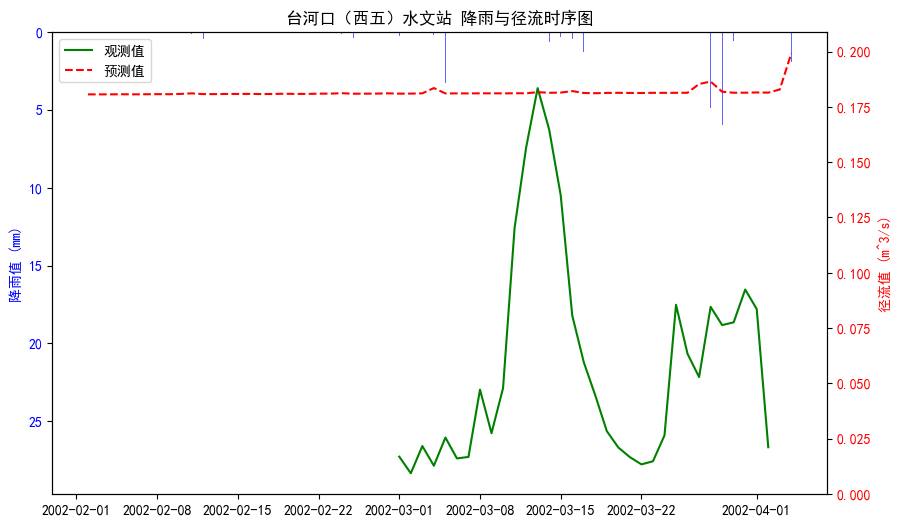

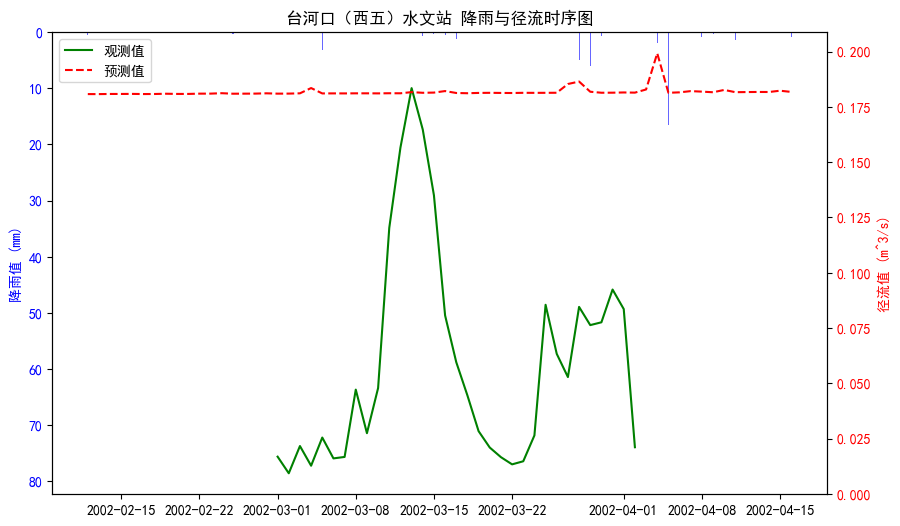

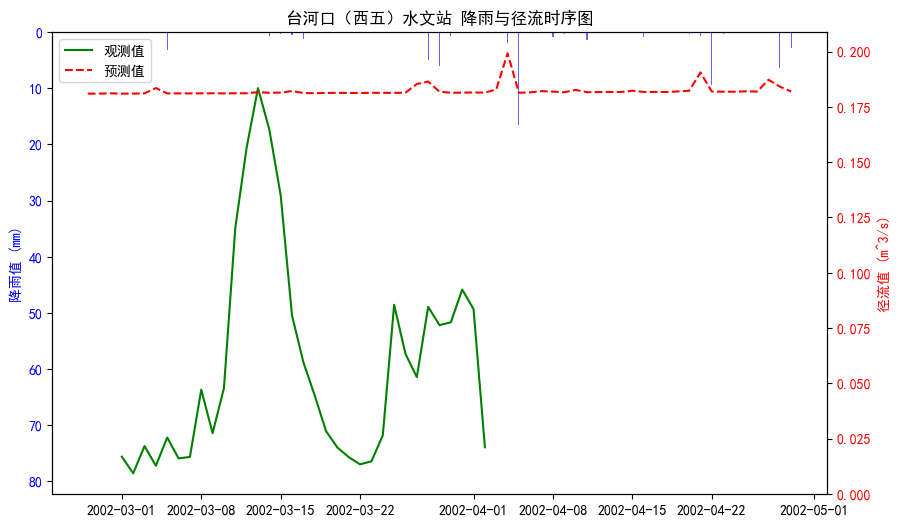

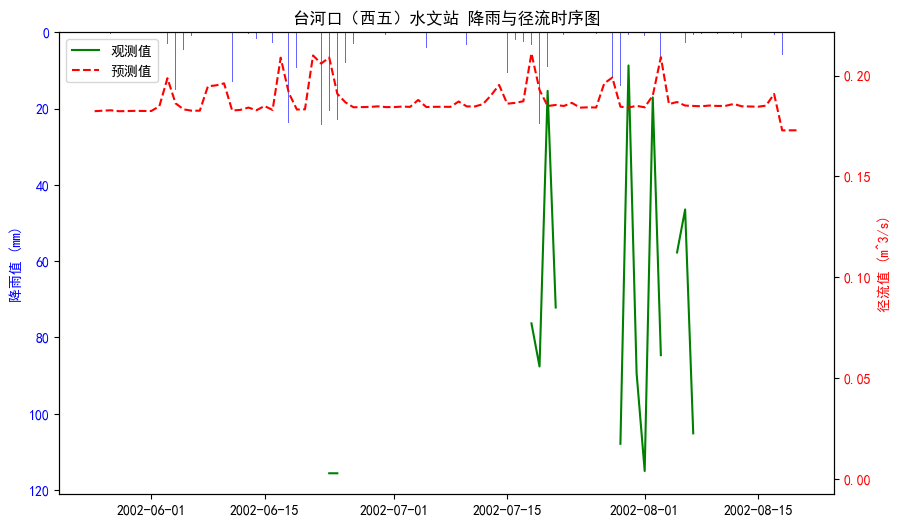

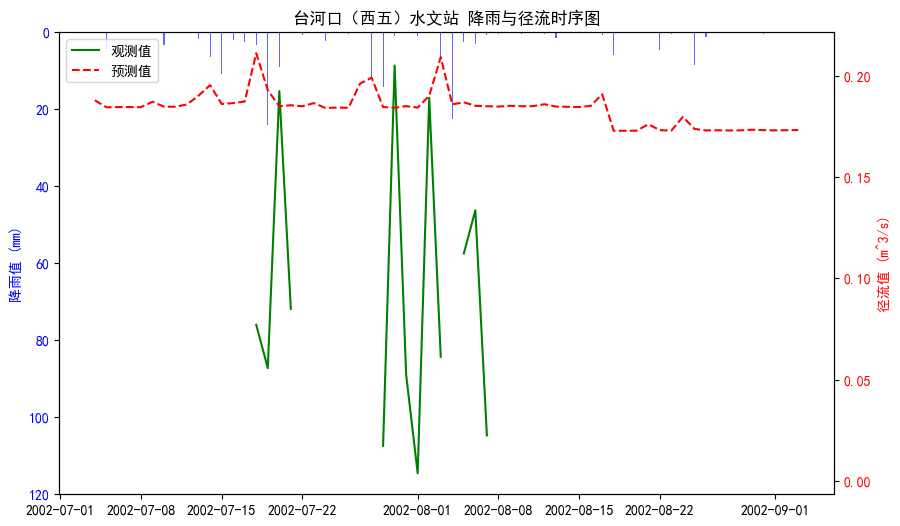

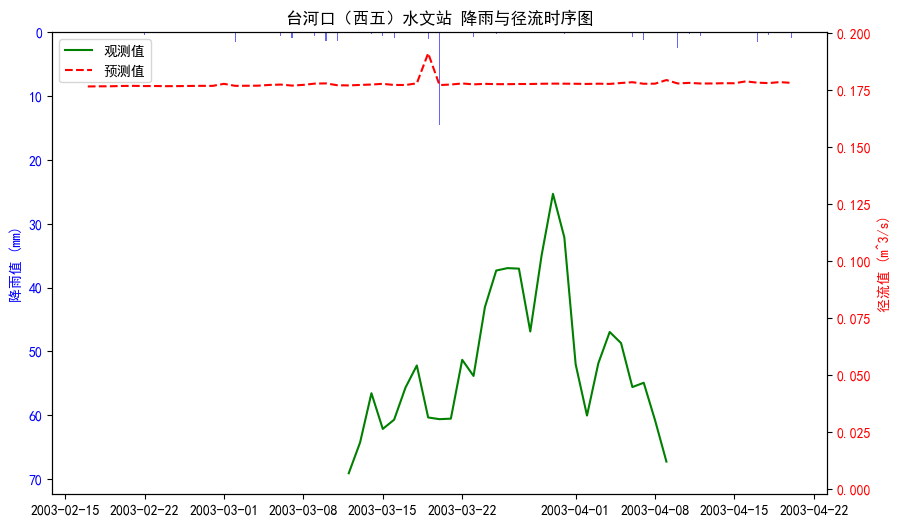

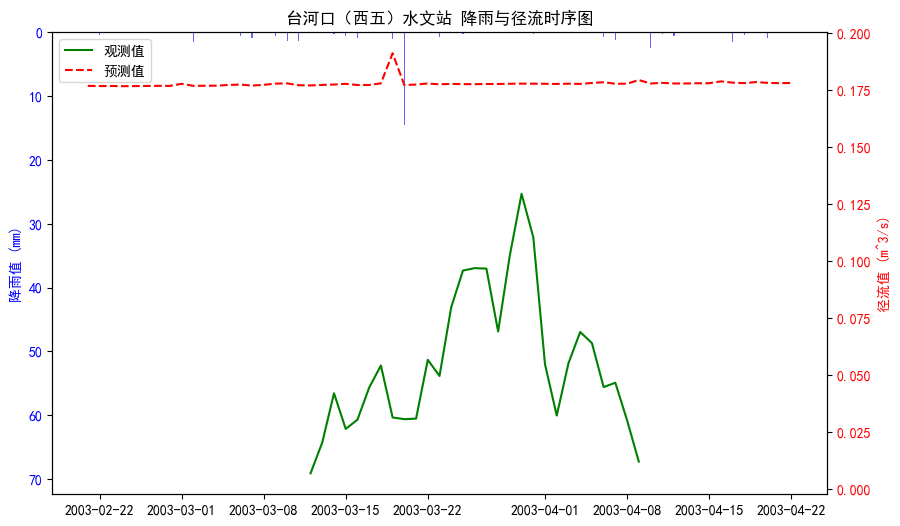

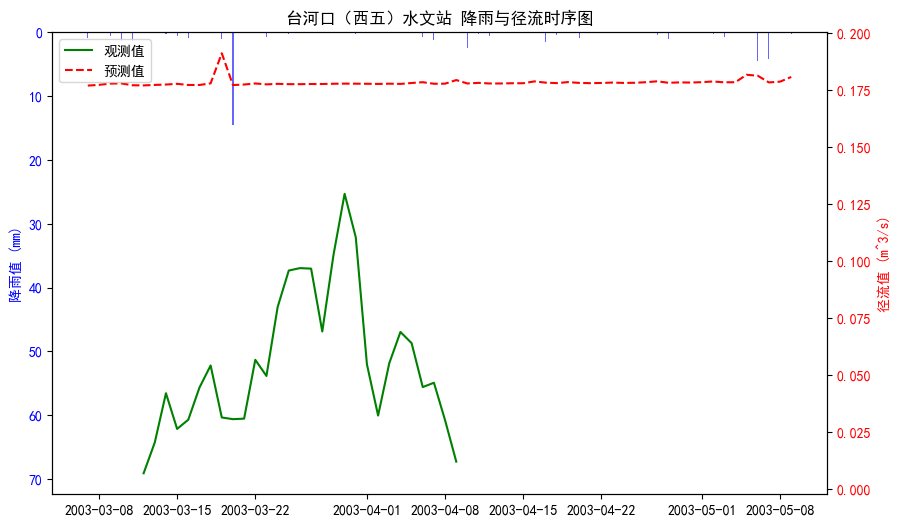

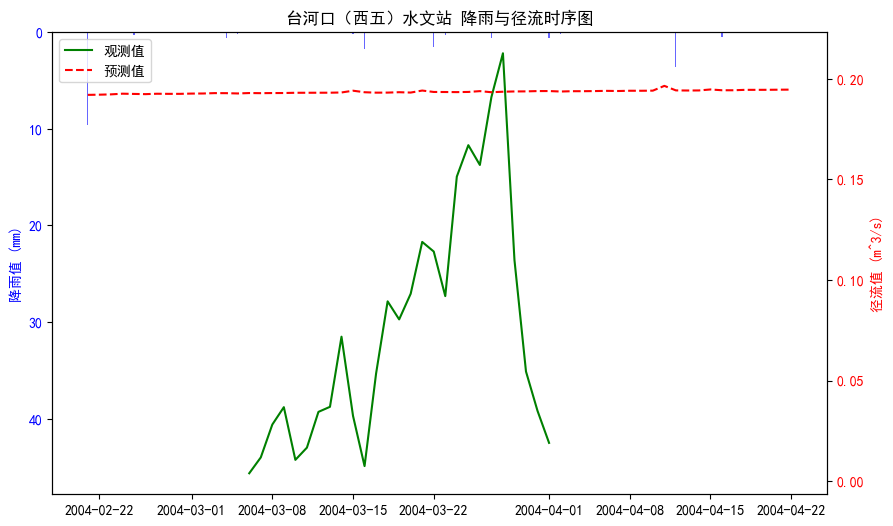

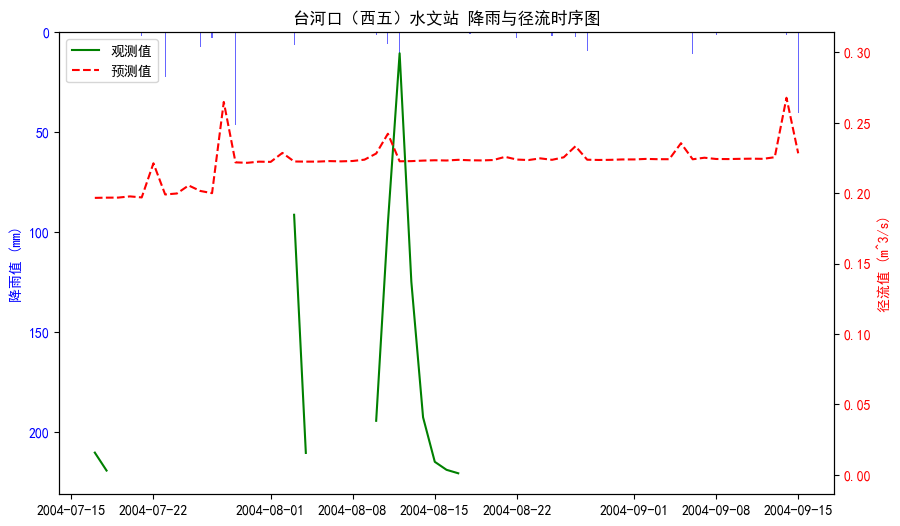

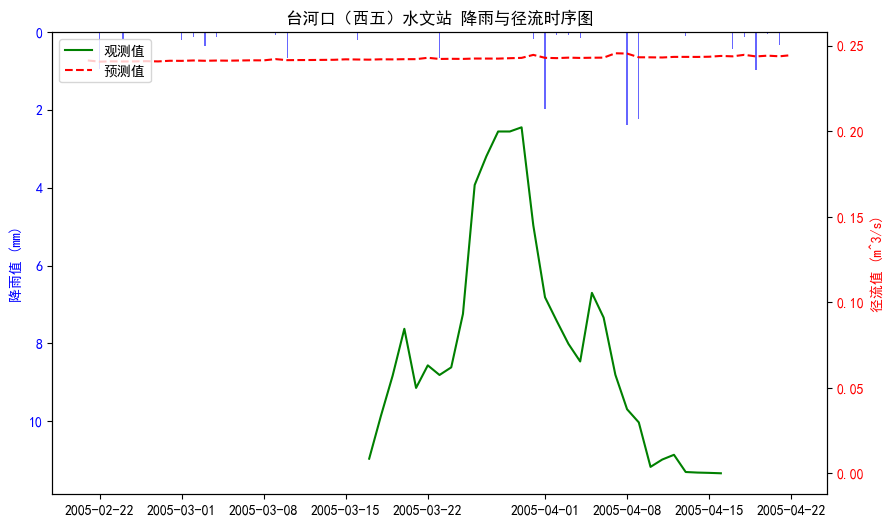

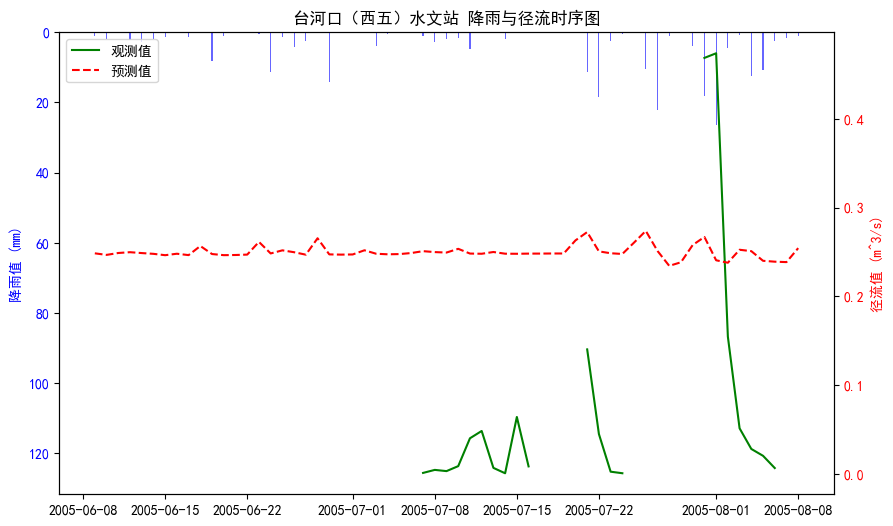

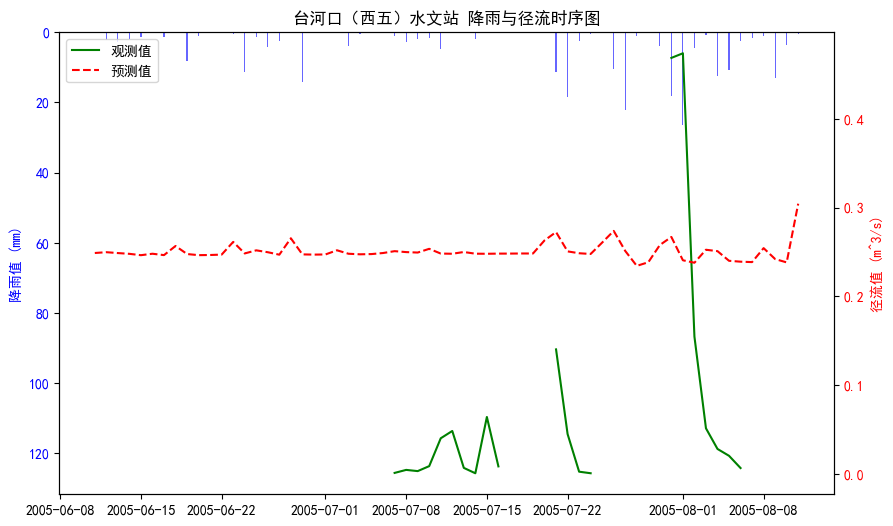

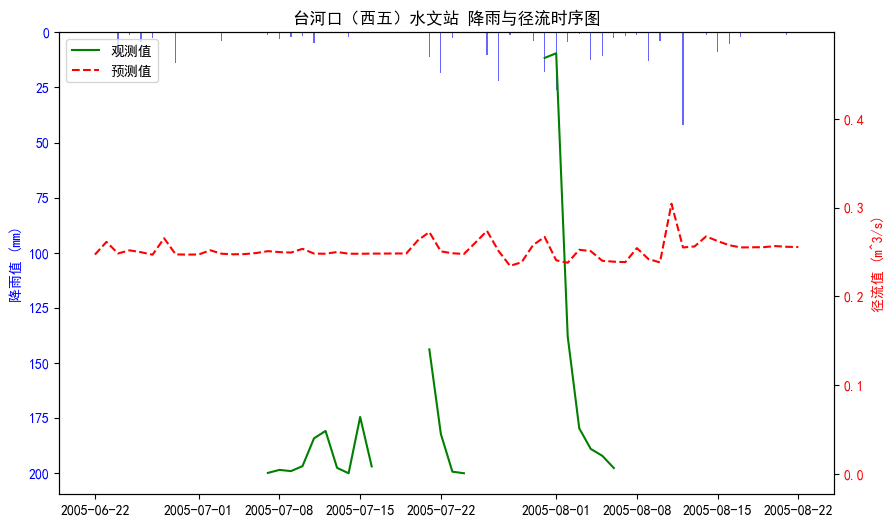

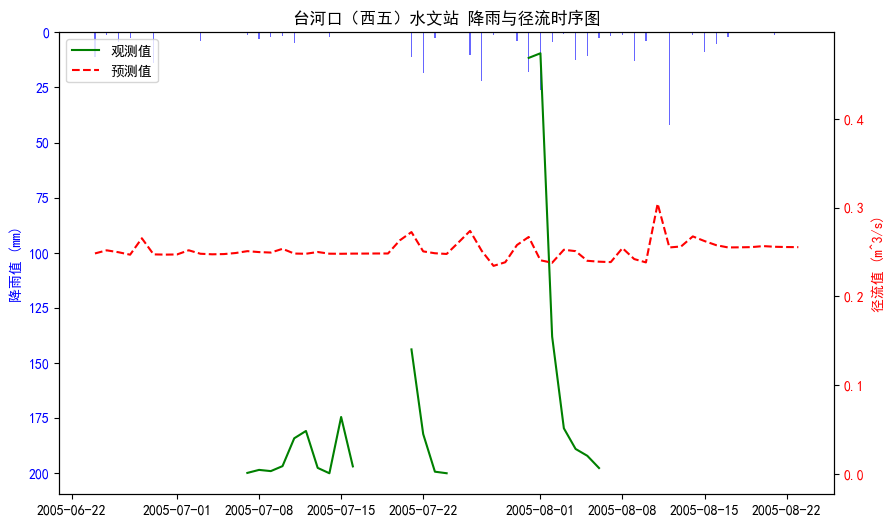

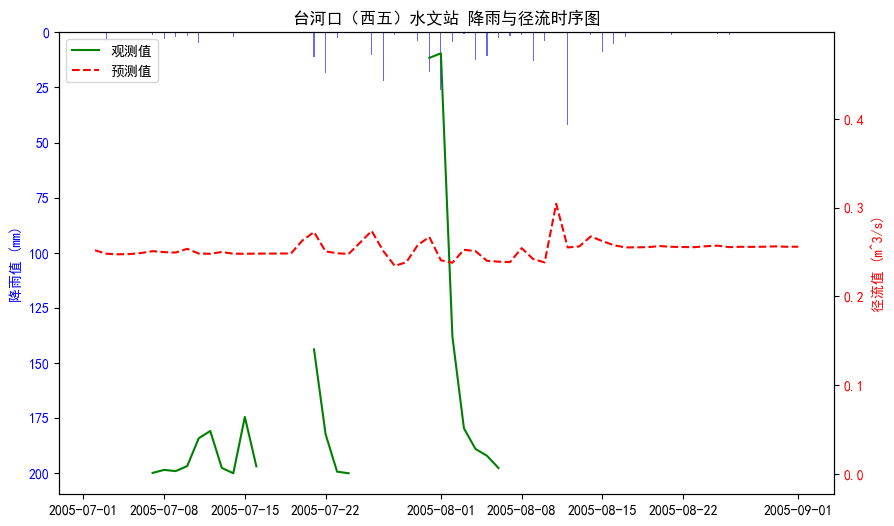

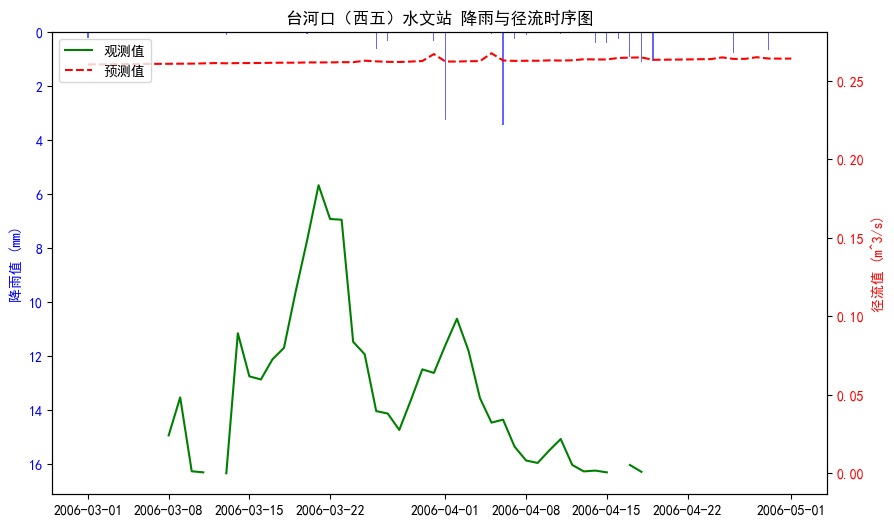

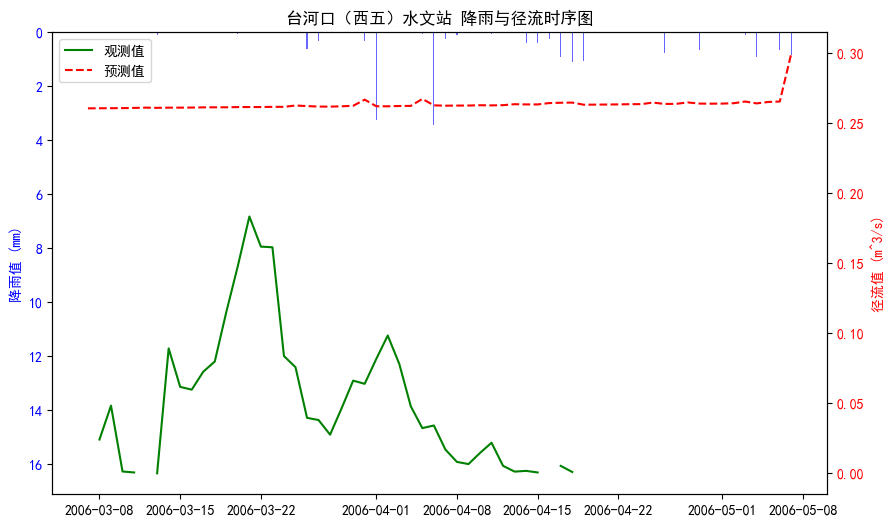

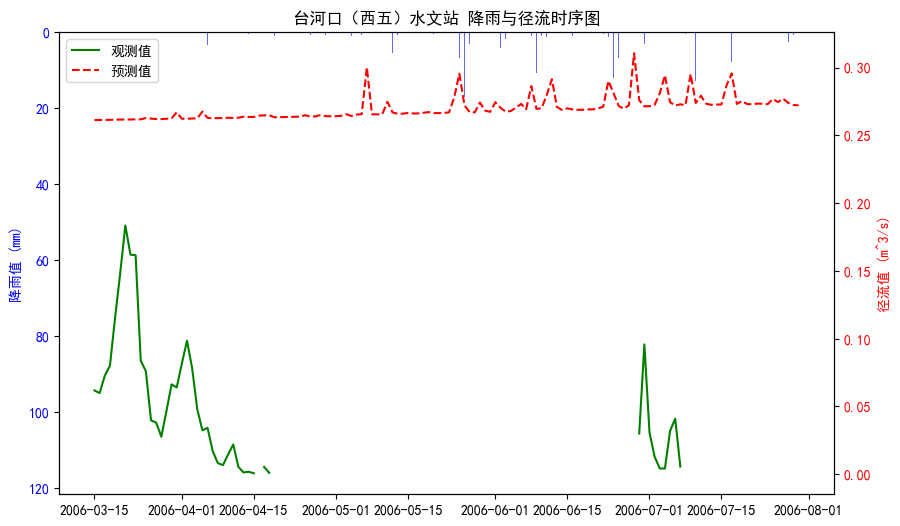

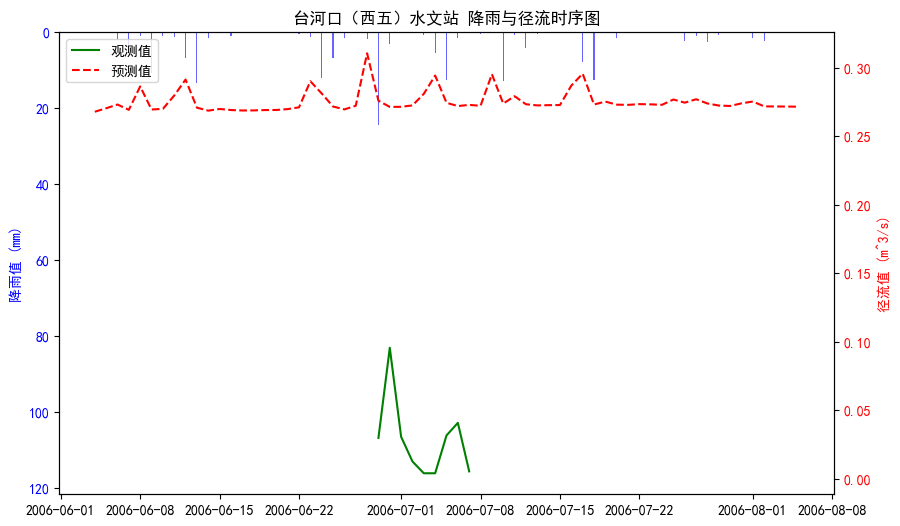

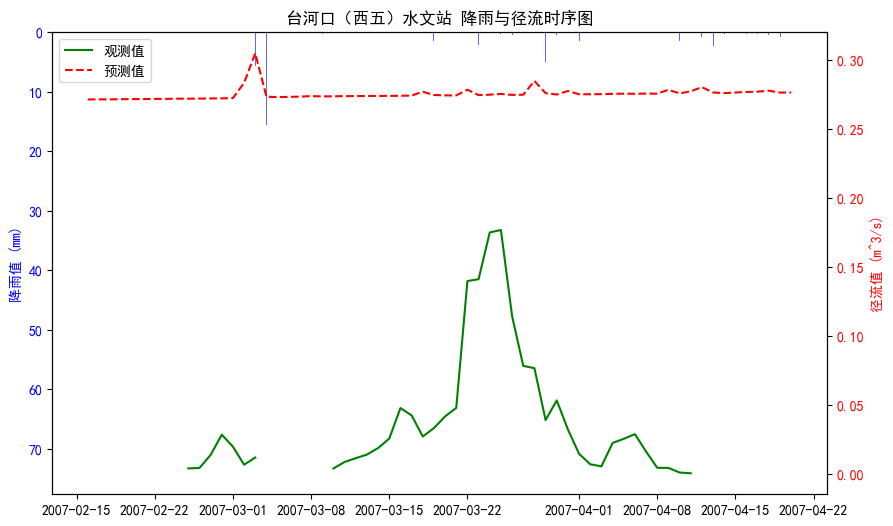

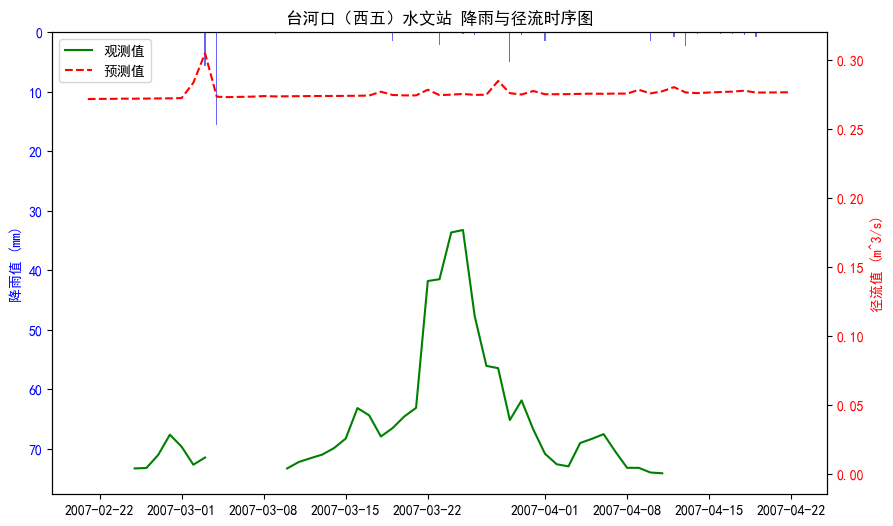

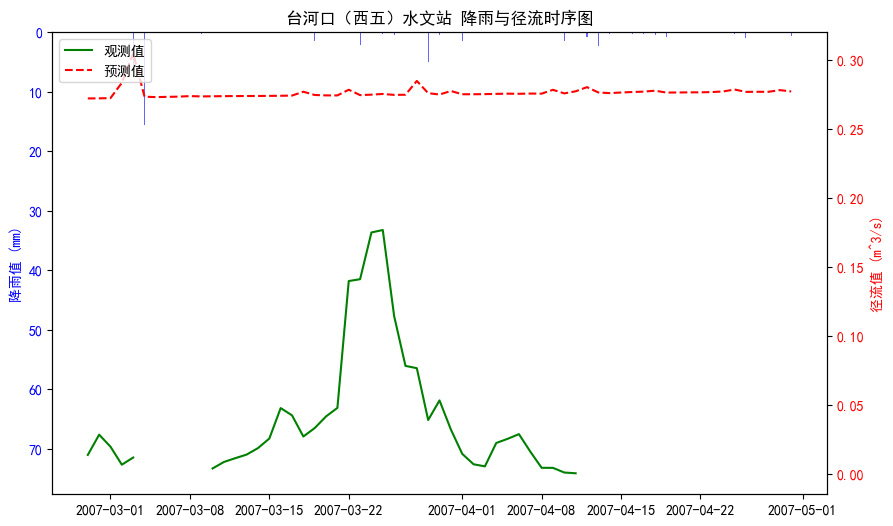

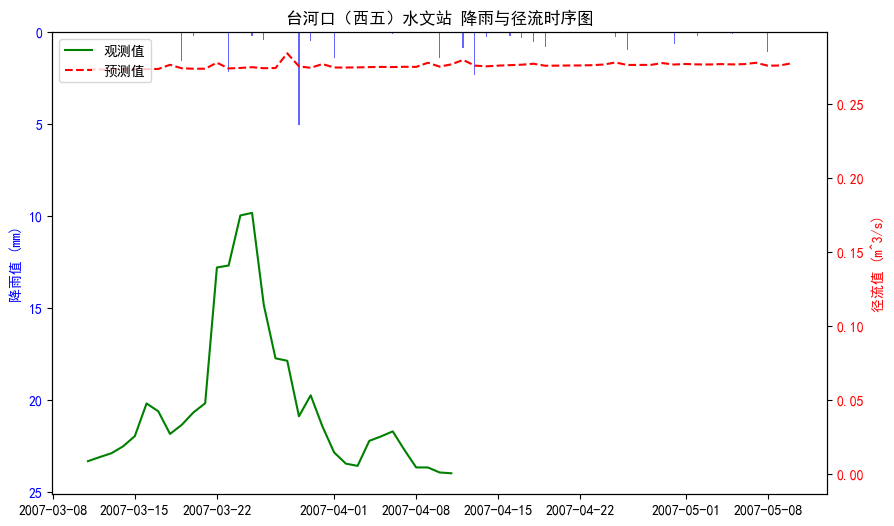

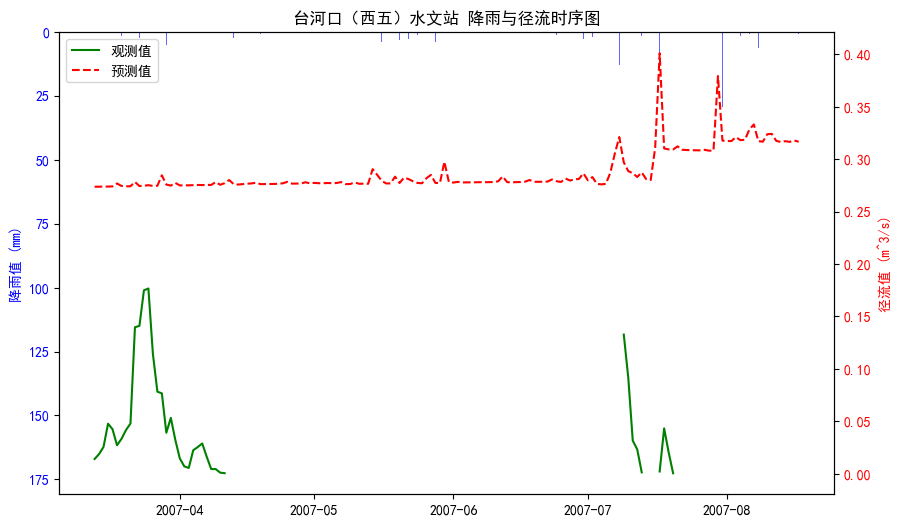

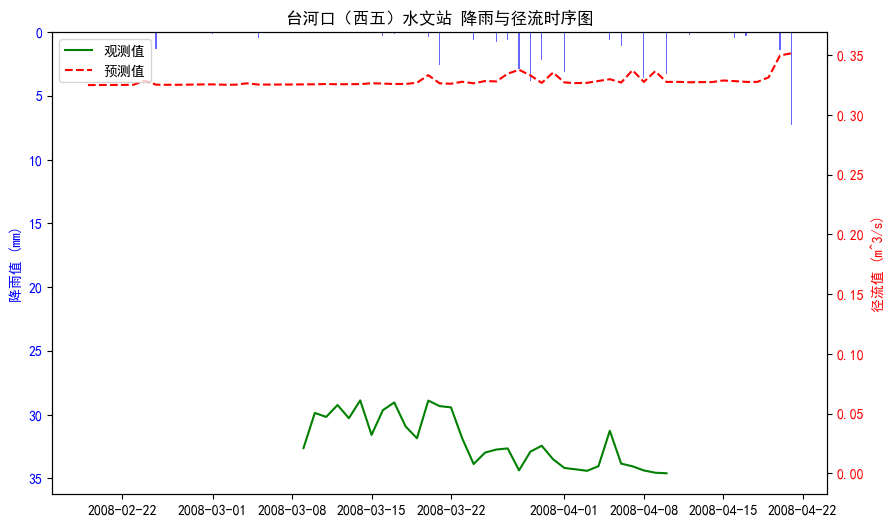

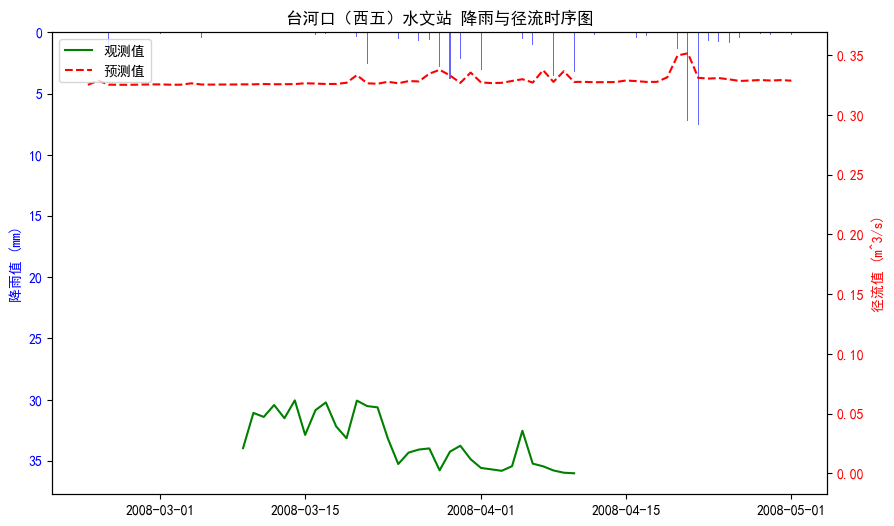

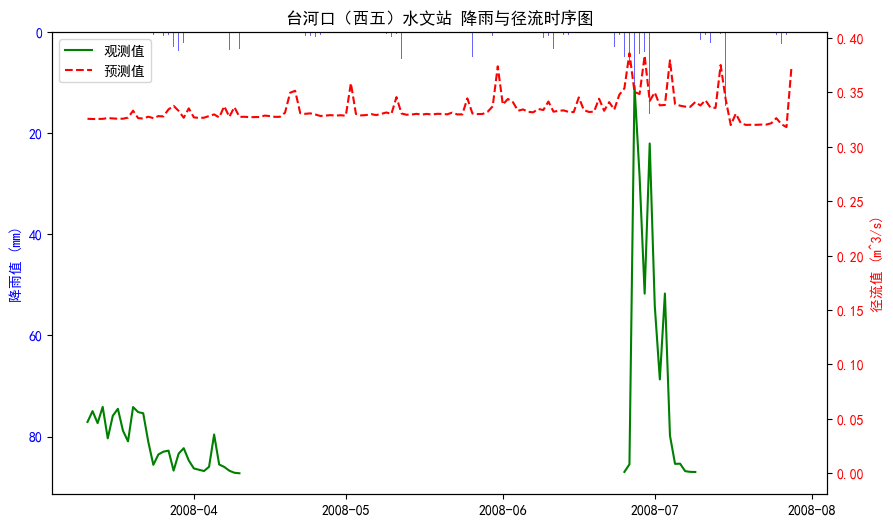

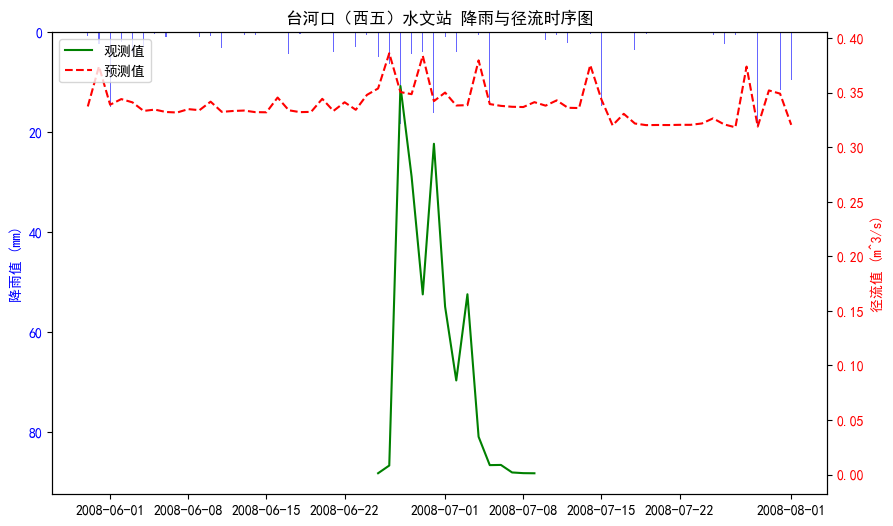

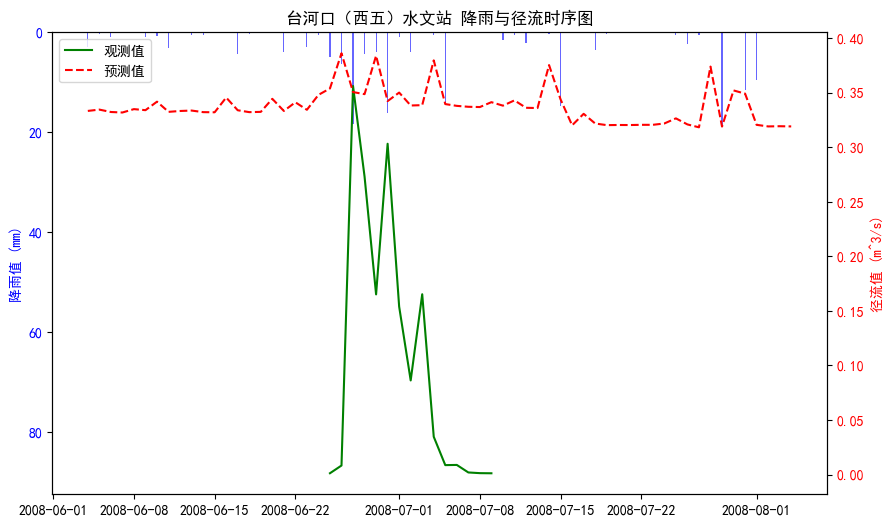

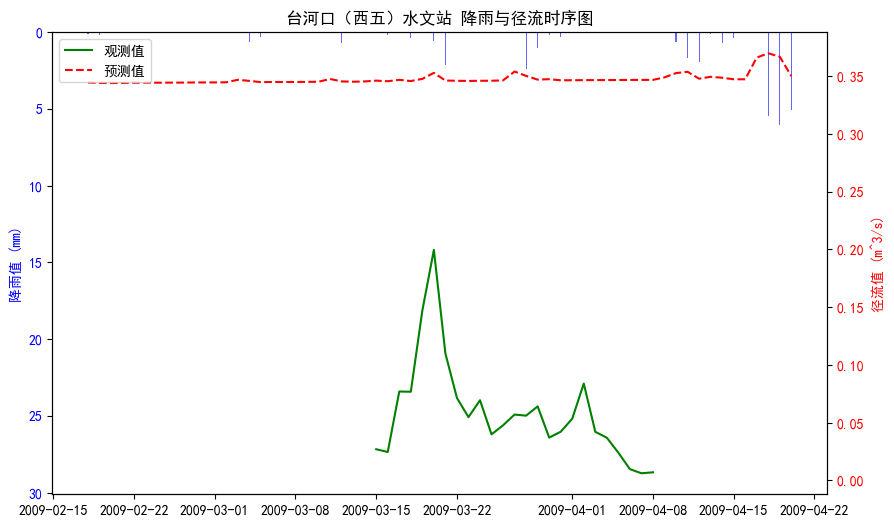

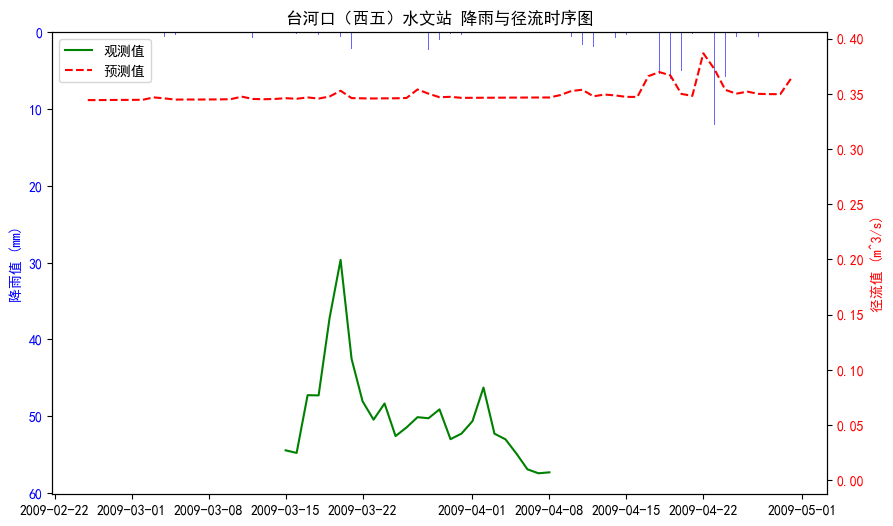

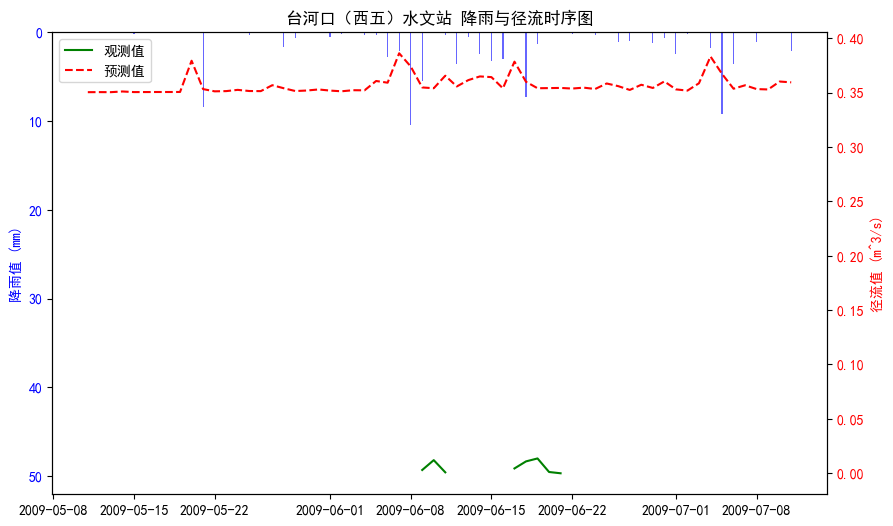

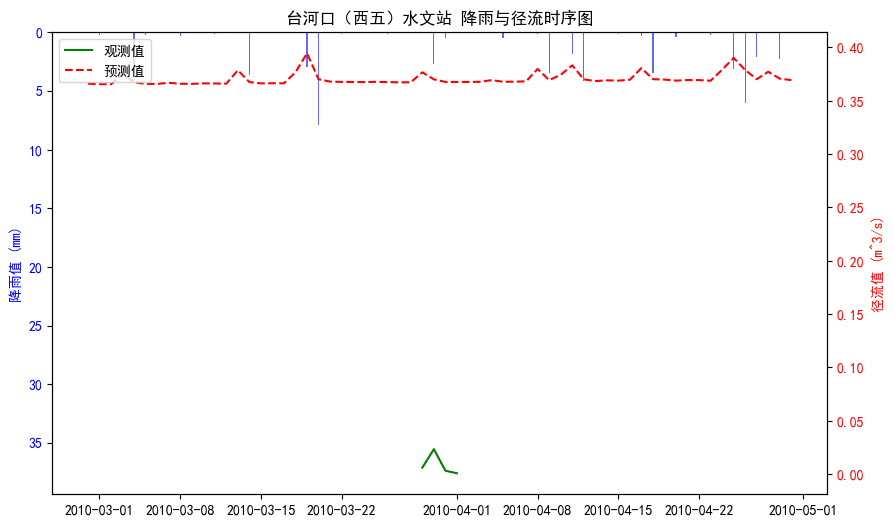

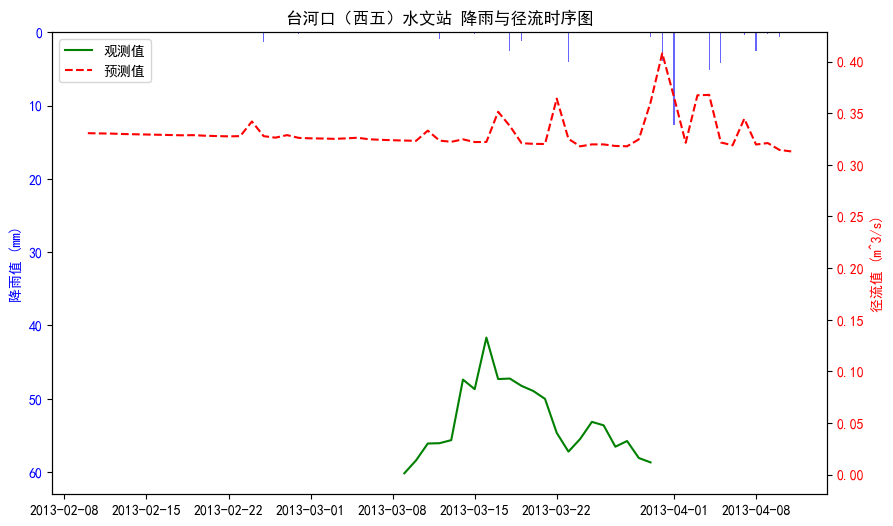

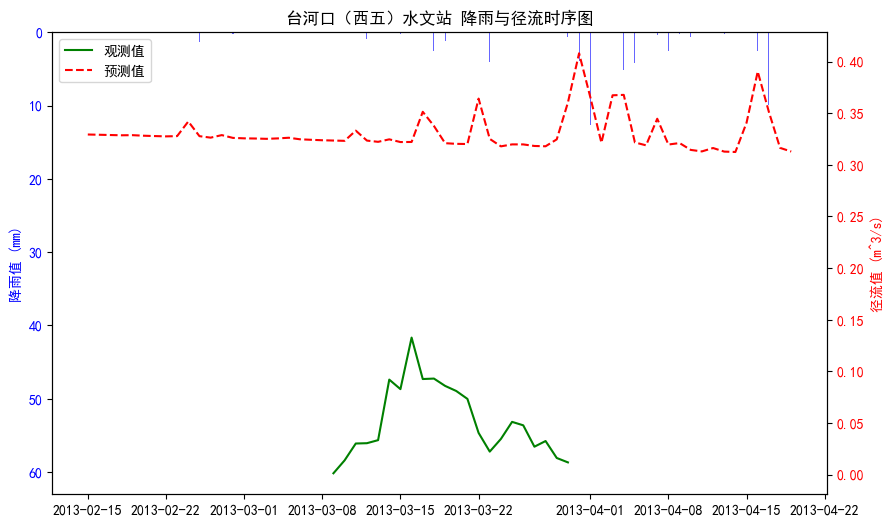

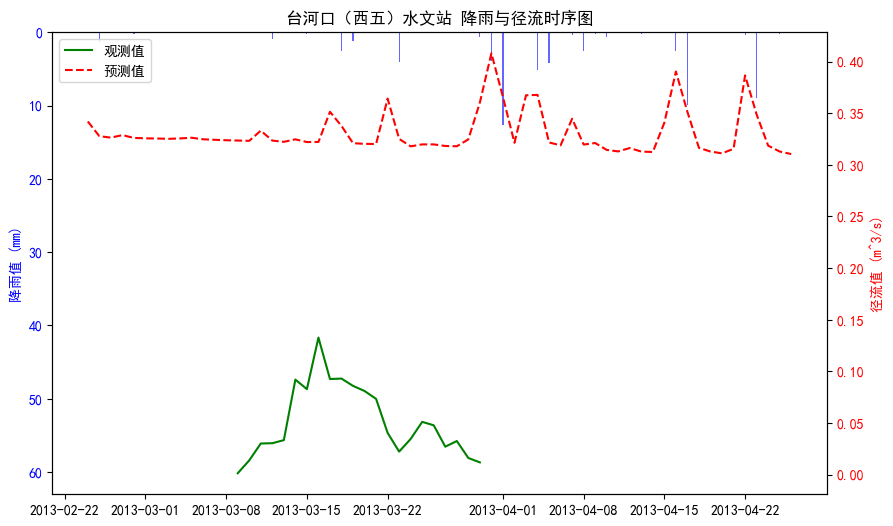

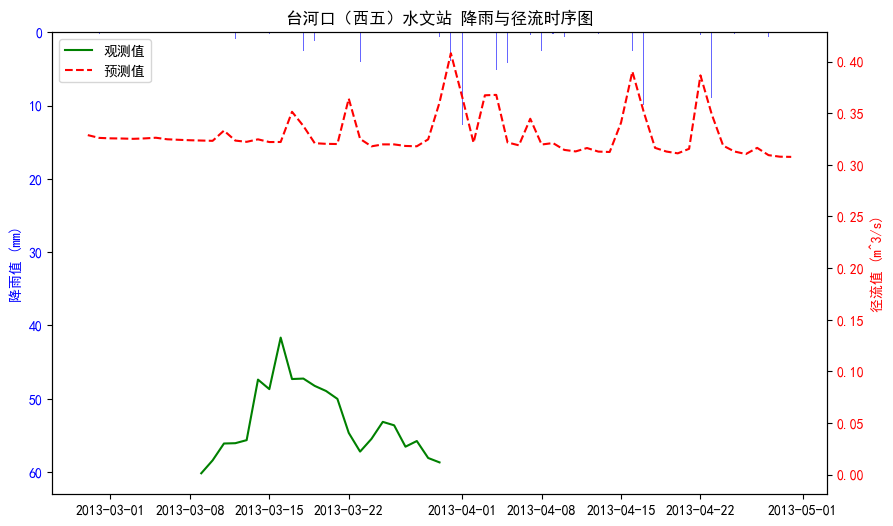

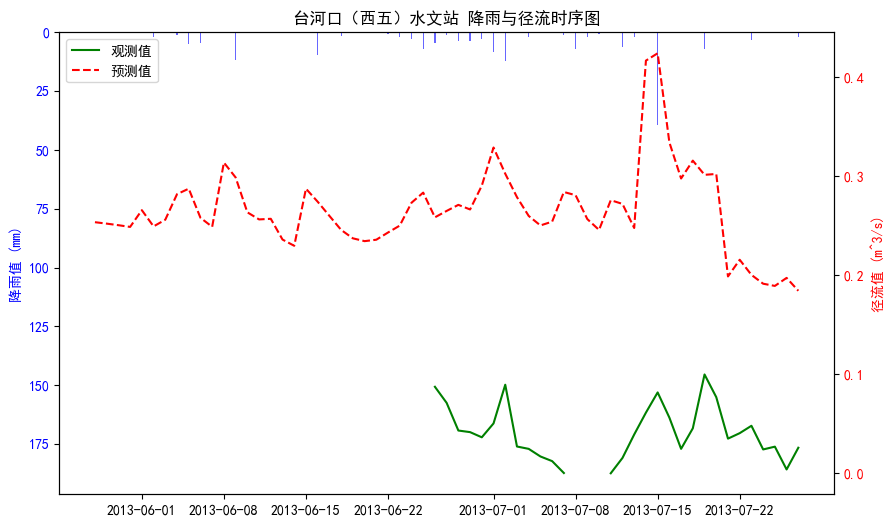

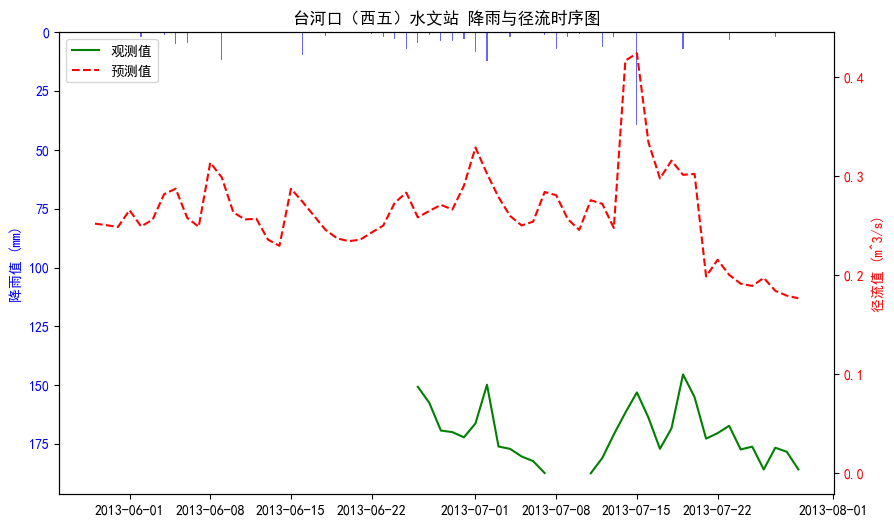

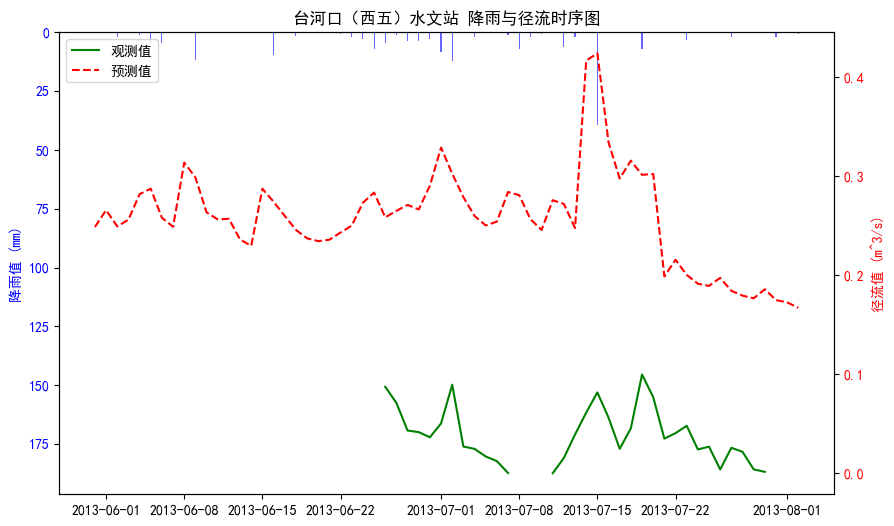

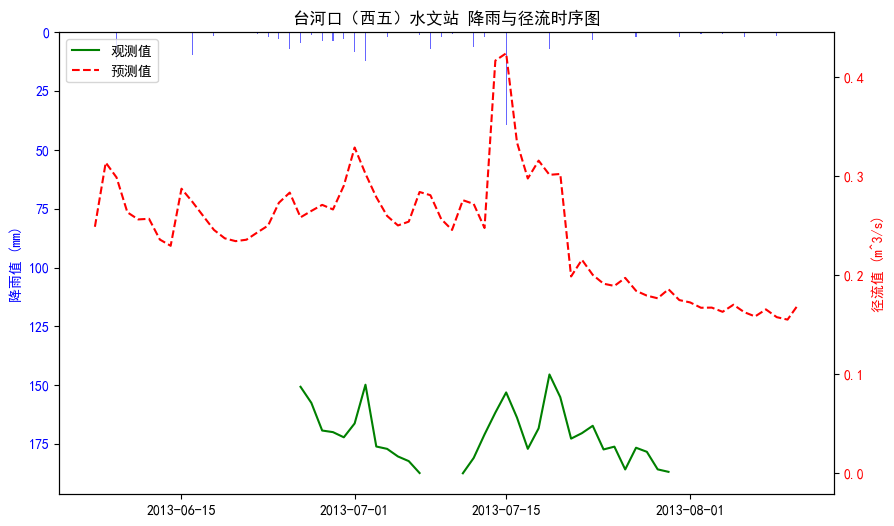

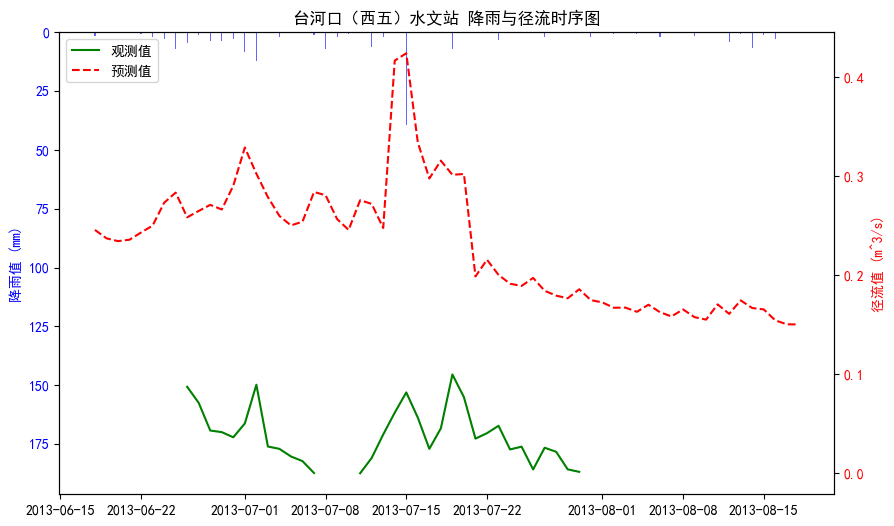

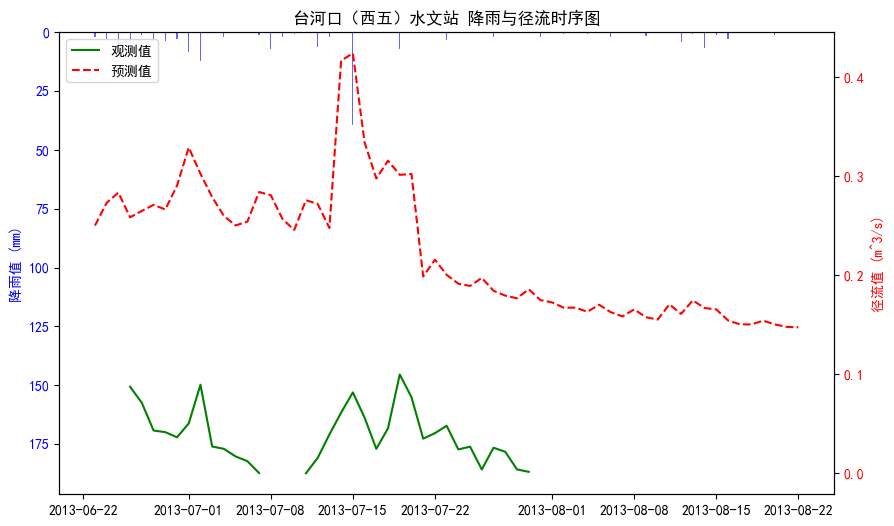

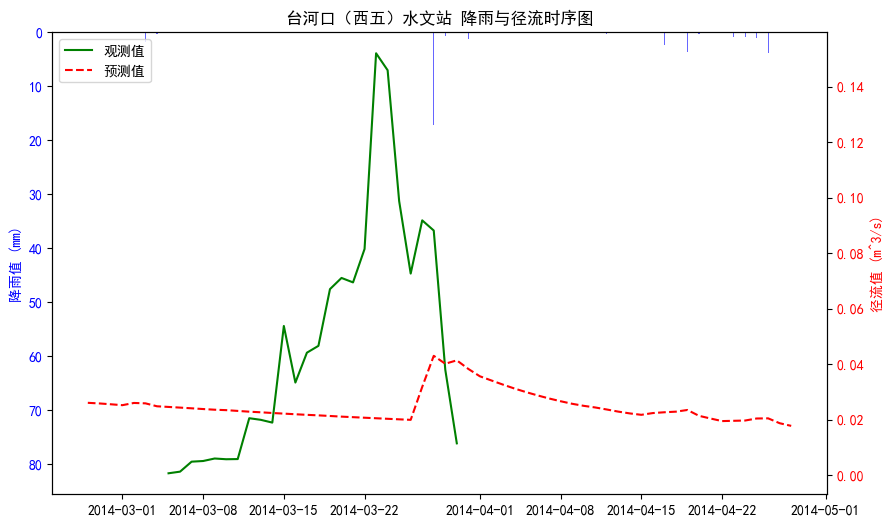

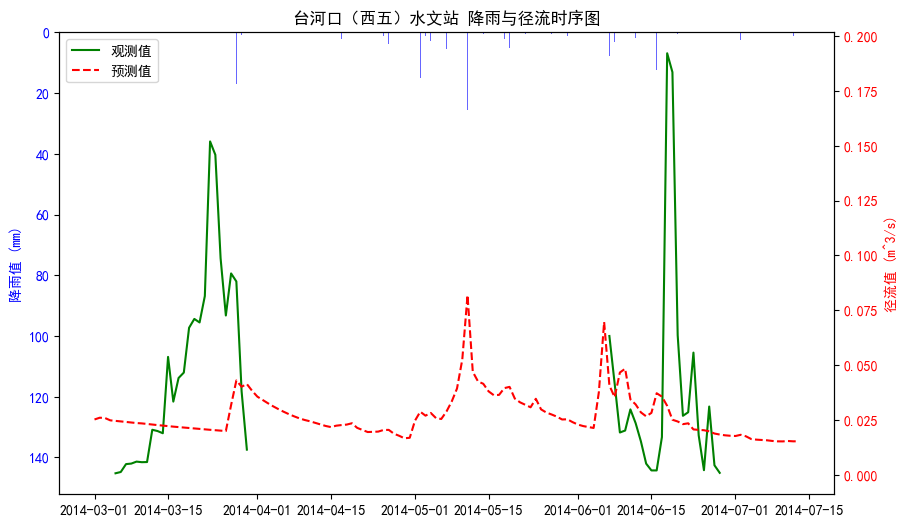

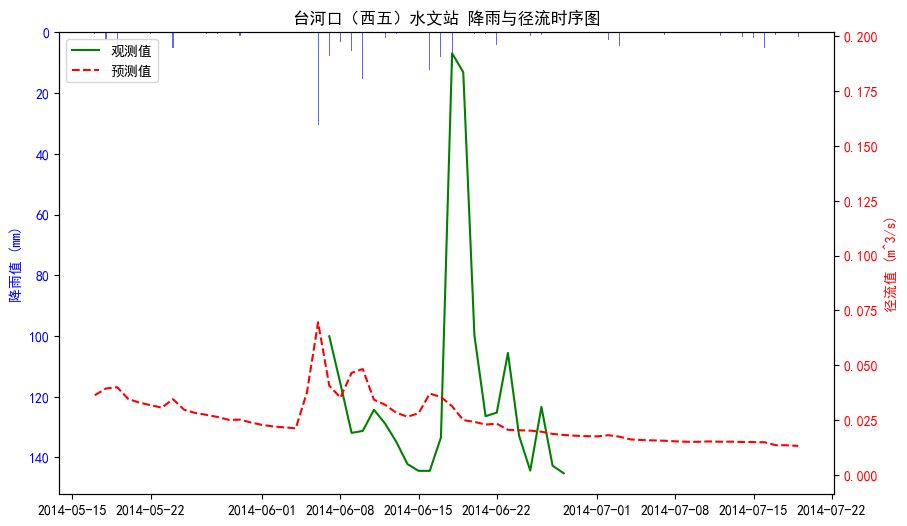

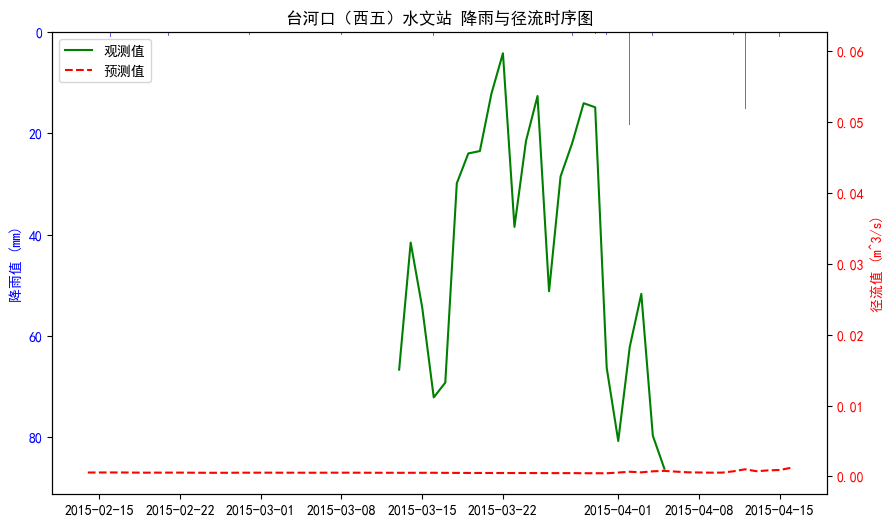

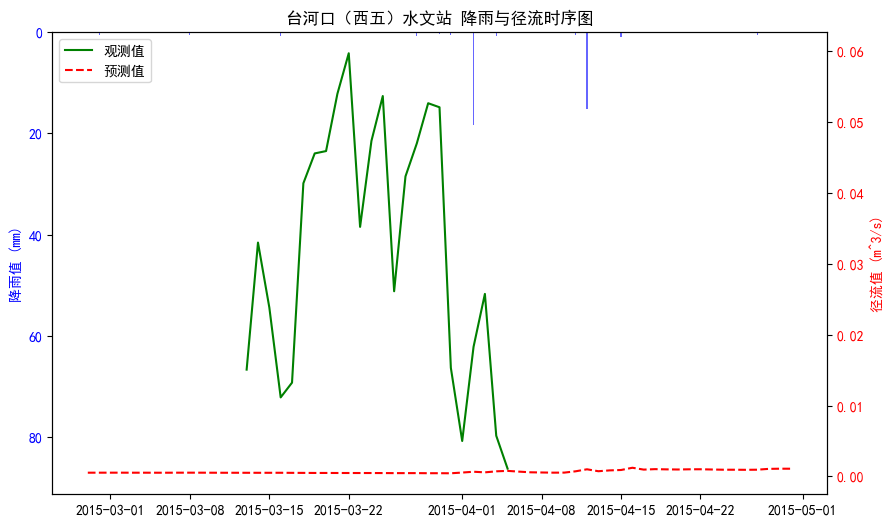

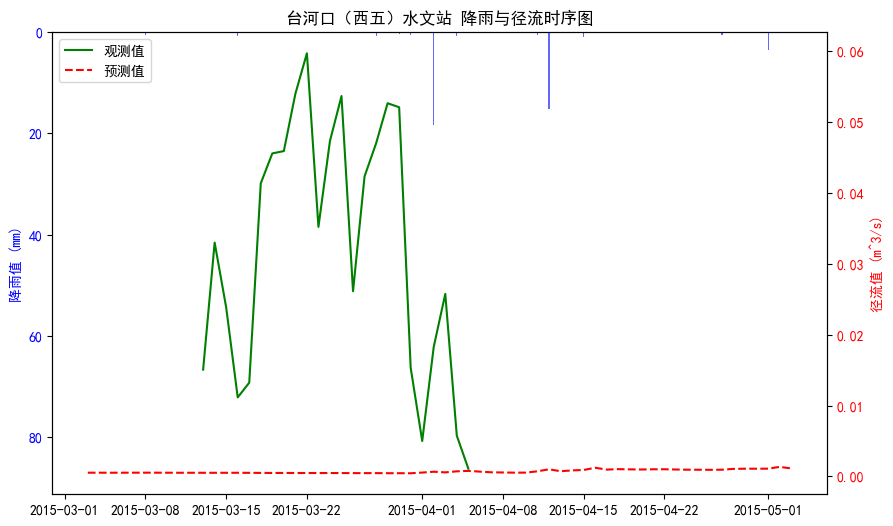

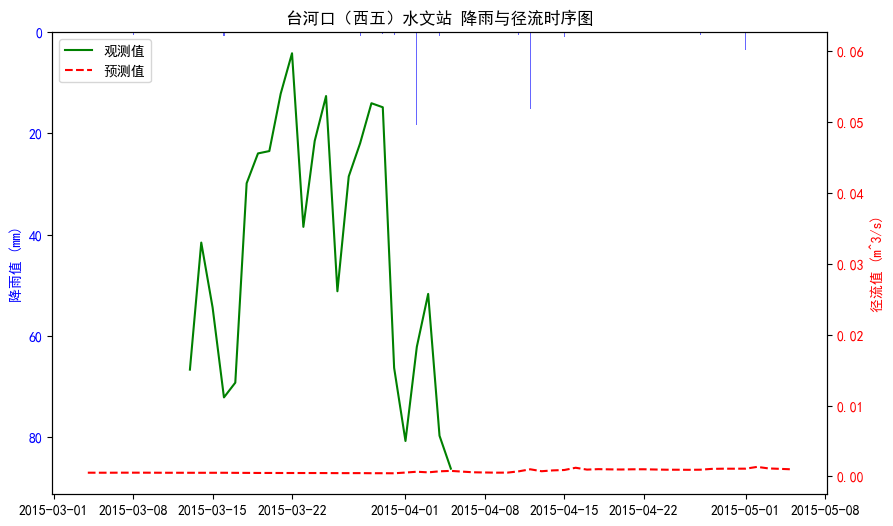

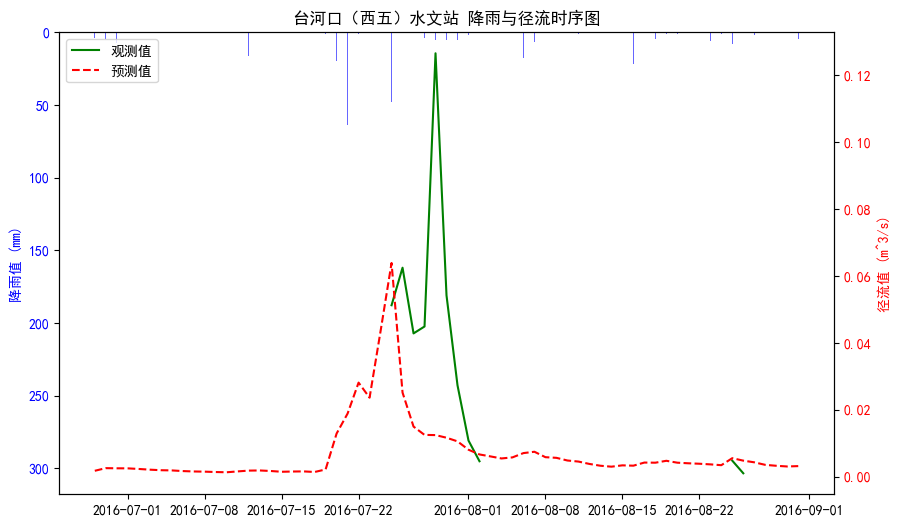

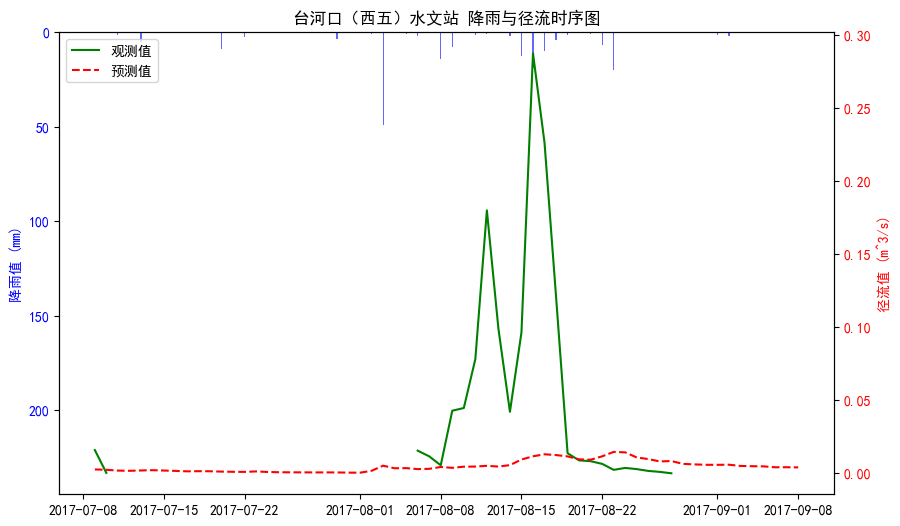

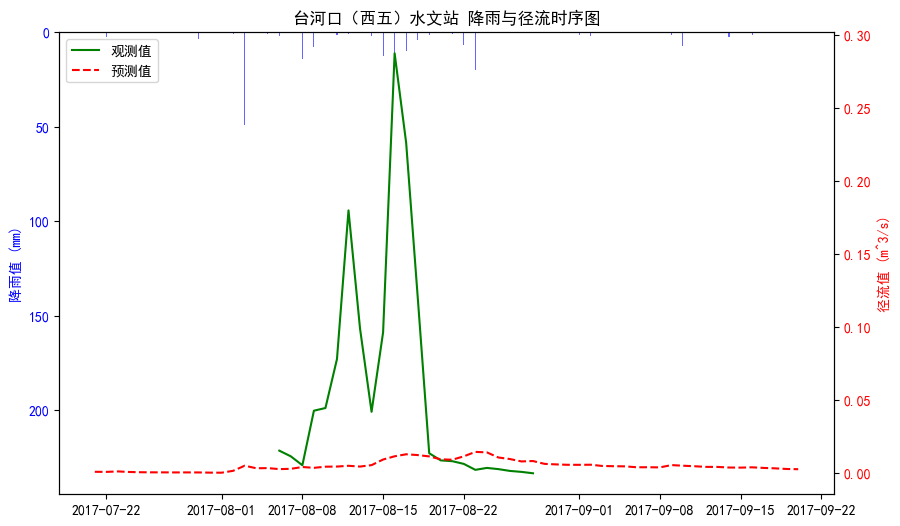

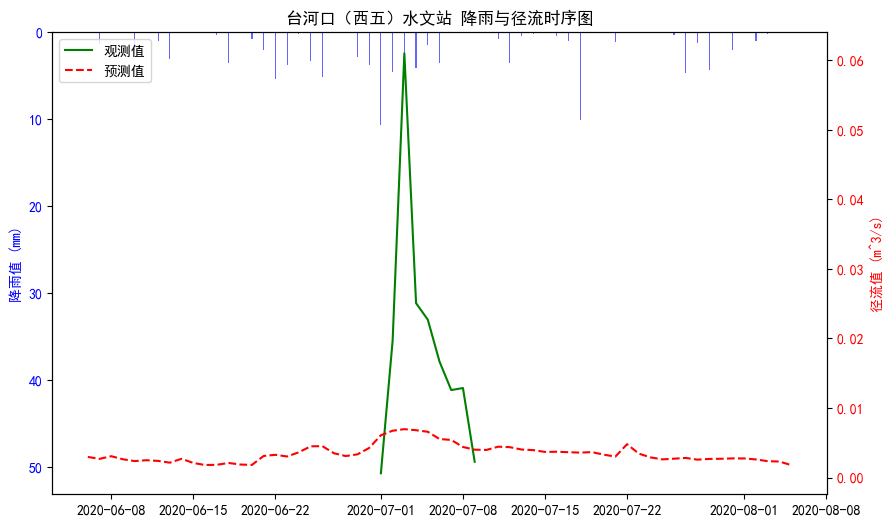

In [41]:
import os
from datetime import datetime,timedelta
import pandas as pd

# 读取场次数据
def read_rainfall_events_summary(csv_file_path):
    summary_df = pd.read_csv(csv_file_path)
    events_dict = {}
    for index, row in summary_df.iterrows():
        basin = row['BASIN']
        start_time = row['BEGINNING_RAIN']
        end_time = row['END_RAIN']
        if basin not in events_dict:
            events_dict[basin] = []
        events_dict[basin].append({
            'Start_Time': start_time,
            'End_Time': end_time
        })
    return events_dict

csv_file_path = './neimenggu_20205510_events.csv'
rainfall_events_summary = read_rainfall_events_summary(csv_file_path)

# 循环字典中的每个流域和对应的事件
for target_basin_id, events in rainfall_events_summary.items():
    for event in events:
        
        time_start = datetime.strptime(event['Start_Time'], '%Y-%m-%d %H:%M:%S')
        time_end = datetime.strptime(event['End_Time'], '%Y-%m-%d %H:%M:%S')
        time_start = time_start - timedelta(days=30) # 增加一月
        time_end = time_end + timedelta(days=30)
        time_start = time_start.strftime('%Y-%m-%d')
        time_end = time_end.strftime('%Y-%m-%d')
        
        time_style = '1D'
        nc_file = f"/home/zlh/.cache/hydro/timeseries_{time_style}_batch_neimenggu_11300301_neimenggu_40701050.nc" # nc文件
        
        output_folder =f'./plt_train_with_camelsandneimeng_{time_style}_era5land_stlflow'
        
        basin_colunms = "basin"
        precip_var = "total_precipitation_hourly"
        flow_var_obs = f"/home/zlh/HydroNeimeng/scripts/results/test_with_era5land/train_with_camelsandneimeng_{time_style}_era5land_mtlflow/epochbest_model.pthflow_obs.nc"
        flow_var_pred = f"/home/zlh/HydroNeimeng/scripts/results/test_with_era5land/train_with_camelsandneimeng_{time_style}_era5land_mtlflow/epochbest_model.pthflow_pred.nc"
        
        print('当前流域：', target_basin_id,'时间段：',time_start,'至',time_end)

        plot_precip_flow(output_folder, nc_file, basin_colunms, precip_var, flow_var_obs, flow_var_pred, target_basin_id,time_style, time_start, time_end)


测试读取events.csv


In [ ]:
import pandas as pd
def read_rainfall_events_summary(csv_file_path):
    summary_df = pd.read_csv(csv_file_path)
    events_dict = {}
    for index, row in summary_df.iterrows():
        basin = row['Basin']
        year = row['Year']
        start_time = row['Start Time']
        end_time = row['End Time']
        if basin not in events_dict:
            events_dict[basin] = []
        events_dict[basin].append({
            'Year': year,
            'Start_Time': start_time,
            'End_Time': end_time
        })
    return events_dict

csv_file_path = '/home/zlh/test/torchhydro/experiments/rainfall_events_summary.csv'

rainfall_events_summary = read_rainfall_events_summary(csv_file_path)

rainfall_events_summary['neimenggu_30704390']
print(rainfall_events_summary['neimenggu_30704390'])
